In [4]:
## Step 1: Mount Google Drive (for accessing dataset and saving the model)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
## Step 2: Import Necessary Libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
## Step 3: Set Dataset Path from Google Drive
dataset_path = '/content/drive/MyDrive/Diseas'  # Change this to your dataset folder path in Drive

In [7]:
## Step 4: Data Preprocessing
image_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,             # Pixel values ko 0-1 range me normalize kiya
    rotation_range=20,          # Image rotate karne ka range 20 degrees
    width_shift_range=0.2,      # Image horizontal shift
    height_shift_range=0.2,     # Image vertical shift
    shear_range=0.2,            # Shear transformation
    zoom_range=0.2,             # Zoom transformation
    horizontal_flip=True,       # Random horizontal flip
    validation_split=0.2        # 80% training, 20% validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 4747 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.


In [8]:
def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]  # Feature map channels count
    se = GlobalAveragePooling2D()(input_tensor)  # Global average pooling
    se = Dense(filters // ratio, activation='relu')(se)  # Reduce feature dimensions
    se = Dense(filters, activation='sigmoid')(se)  # Learn channel-wise weights
    return Multiply()([input_tensor, se])  # Multiply with original input


In [9]:
def swisennet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (3,3), activation='swish', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = squeeze_excite_block(x)  # SE block apply kiya

    x = Conv2D(128, (3,3), activation='swish', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = squeeze_excite_block(x)

    x = Conv2D(256, (3,3), activation='swish', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = squeeze_excite_block(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='swish')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)
    return model


In [10]:
model = swisennet_model((150,150,3), 4) # 4 Classes: Bacterial Blight, Blast, Brown Spot, Tungro
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 150, 150, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 75, 75, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ max_pooling2d[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4)              │            260 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │            320 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 75, 75, 64)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 75, 75, 128)    │         73,856 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 37, 37, 128)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ max_pooling2d_1[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8)              │          1,032 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │          1,152 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 37, 37, 128)    │              0 │ max_pooling2d_1[0][0], │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 37, 37, 256)    │        295,168 │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 18, 18, 256)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_2[0][0]  │
│ (GlobalAveragePooling

 Total params: 415,456 (1.58 MB)

 Trainable params: 415,456 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
epochs = 20

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1601s 11s/step - accuracy: 0.3405 - loss: 1.3083 - val_accuracy: 0.6034 - val_loss: 0.9971
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 55s 371ms/step - accuracy: 0.6072 - loss: 0.9624 - val_accuracy: 0.6540 - val_loss: 0.8854
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 57s 382ms/step - accuracy: 0.6901 - loss: 0.7702 - val_accuracy: 0.7586 - val_loss: 0.6521
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 55s 371ms/step - accuracy: 0.7731 - loss: 0.5711 - val_accuracy: 0.7494 - val_loss: 0.6340
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 57s 379ms/step - accuracy: 0.8140 - loss: 0.4846 - val_accuracy: 0.8371 - val_loss: 0.4228
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 55s 372ms/step - accuracy: 0.8611 - loss: 0.3715 - val_accuracy: 0.8557 - val_loss: 0.3653
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 56s 378ms/step - accuracy: 0.8682 - loss: 0.3387 - val_accuracy: 0.8776 - val_loss: 0.3064
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 55s 371ms/step - accuracy: 0.8975 - loss: 0

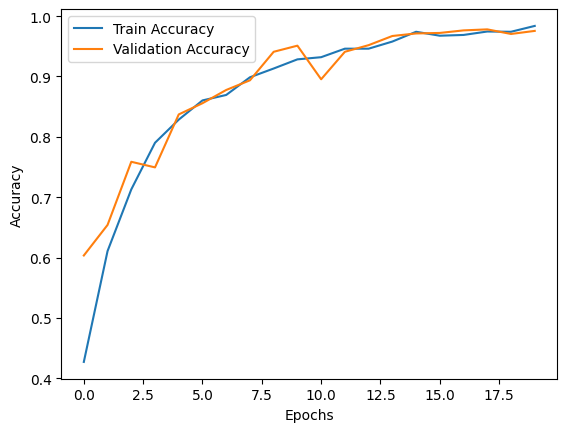

In [12]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [15]:
model.save("/content/drive/MyDrive/paddy_disease_model.keras")



In [16]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/paddy_disease_model.keras")



/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [27]:
## Step 10: Make Predictions
import random
from tensorflow.keras.preprocessing import image

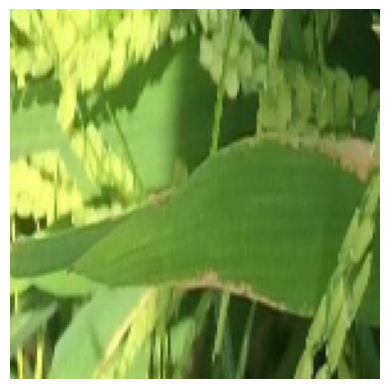

In [37]:
# Select a random image from validation set
random_image_path = random.choice(val_generator.filepaths)
img = image.load_img(random_image_path, target_size=image_size)
plt.imshow(img)
plt.axis('off')
plt.show()

In [38]:

# Preprocess the image
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

In [36]:
# Predict
y_pred = model.predict(img_array)
pred_class = np.argmax(y_pred)
print(f"Predicted Class: {list(train_generator.class_indices.keys())[pred_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Class: Tungro
